The goal of this project is to identify the breed of a dog in a supplied image. We will do this by building, training, and testing a convolutional neural network which does the identifying.

In this notebook, we will:
1. Load data from Kaggle
2. Load Labels csv for labels that contain image ID and breed
3. Check the breed count
4. One hot encode on labels data prediction column
5. Load the images, convert them to an array, and normalize them
6. Check the shape and size of the X and Y data
7. Build the model neural network architecture
8. Split the data and fit into the model, and create an accuracy plot
9. Evaluate the model for accuracy score
10. Make predictions using the model

Import the relevant libraries.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Read in the labels.csv file and check shape and records.

In [2]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Visualize the number of each breed.

In [3]:
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

Due to compute power, select the first three breeds. If you have more compute power, you can select more breeds.

In [4]:
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


Since this is a classification dataset, we need to one hot encode the target value (the classes). After that, we can read images and convert them to numpy arrays so that we can normalize them.

In [5]:
# Create numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype = 'float32')

# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Read and convert image to numpy array and normalize the dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size = (224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Print train image and one hot encode shape and size
print('\nTrain Images Shape: ', X_data.shape, ' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ', Y_data.shape, ' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:03<00:00, 112.54it/s]


Train Images Shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


Now we can build the model. The hyperparameters can be tuned to potentially improve the accuracy of the model. Conv_2D is used to create a convolution kernel that is convolved with the input layer to product the output tensor. Max_Pooling2D is a downsampling technique which takes out the maximum value over the window defined by pool_size. Flatten flattens the input and creates a 1D output. Dense produces the output as the dot product of the input and the kernel. 

In [17]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 16, kernel_size = (7, 7), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 8, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(len(CLASS_NAMES), activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 16)      

After defining the network architecture, we found that the total number of parameters was 162, 619. Now we can run a train - test - split.

In [18]:
# Split the data into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)

# Split the training data set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size=0.2)

Now we can train the mode. We will use 100 epochs, but more can be added to increase the accuracy. We can see how the model is performing by viewing the training and validation accuracy.

In [19]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs=epochs, validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 46s 18s/step - loss: 1.0962 - accuracy: 0.3633 - val_loss: 1.0935 - val_accuracy: 0.3385
Epoch 2/100
2/2 [==============================] - 46s 21s/step - loss: 1.0912 - accuracy: 0.3594 - val_loss: 1.0941 - val_accuracy: 0.3385
Epoch 3/100
2/2 [==============================] - 37s 21s/step - loss: 1.0873 - accuracy: 0.3516 - val_loss: 1.0898 - val_accuracy: 0.3385
Epoch 4/100
2/2 [==============================] - 33s 17s/step - loss: 1.0824 - accuracy: 0.3594 - val_loss: 1.0863 - val_accuracy: 0.3385
Epoch 5/100
2/2 [==============================] - 35s 14s/step - loss: 1.0765 - accuracy: 0.3672 - val_loss: 1.0817 - val_accuracy: 0.3385
Epoch 6/100
2/2 [==============================] - 33s 18s/step - loss: 1.0705 - accuracy: 0.3711 - val_loss: 1.0784 - val_accuracy: 0.3692
Epoch 7/100
2/2 [==============================] - 27s 14s/step - loss: 1.0642 - accuracy: 0.3711 - val_loss: 1.0728 - val_accuracy: 0.3692
Epoch 8/100
2/2 [===

We can analyze how the model is learning with each epoch in terms of accuracy.

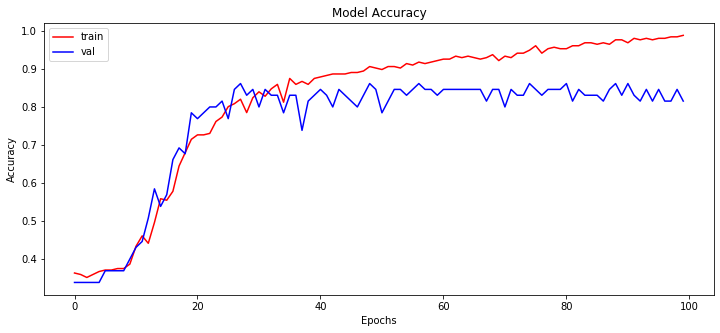

In [21]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Now we can make predictions and find the accuracy on the test set.

In [22]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 1s 167ms/step - loss: 0.8919 - accuracy: 0.8333
Accuracy over the test set: 
 83.33 %


Now we can plot the image to compare, find the max value from the prediction list, and compare the original value to the max value.

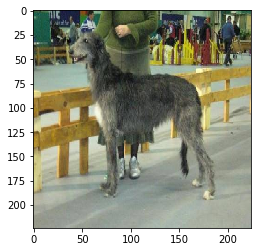

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [25]:
# Plot the image to compare
plt.imshow(X_test[2,:,:,:])
plt.show()

# Find max value from the prediction list and compare the original value vs predicted
print('Originally : ', labels['breed'][np.argmax(Y_test[2])])
print('Predicted : ', labels['breed'][np.argmax(Y_pred[2])])

Save the model to be used in the Flask App.

In [26]:
model.save('dog_breed.h5')